# Getting familiar with deep Q-networks
> Notes on the seminal Deep Q-Networks *Nature* paper from Deepmind.

- branch: 2020-04-03-deep-q-networks
- badges: true
- image: images/q-network-architecture.jpg
- comments: true
- author: David R. Pugh
- categories: [pytorch, deep-reinforcement-learning, deep-q-networks]

## Colab specific environment setup

If you are playing around with this notebook on Google Colab, then you will need to run the following cell in order to install the required dependencies into the environment.

In [134]:
!conda install --yes --channel pytorch --channel conda-forge pytorch=1.4 pandas=1.0 scipy=1.4 swig=4.0
!pip install gym[box2d]==0.17.*

Solving environment: done

## Package Plan ##

  environment location: /Users/pughdr/Research/stochastic-expatriate-descent/env

  added / updated specs:
    - pytorch=1.4
    - scipy=1.4
    - swig=4.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1f             |       h0b31af3_0         1.9 MB  conda-forge
    pcre-8.44                  |       h4a8c4bd_0         222 KB  conda-forge
    scipy-1.4.1                |   py37hce1b9e5_2        18.9 MB  conda-forge
    swig-4.0.1                 |       h6de7cb9_0         1.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        22.1 MB

The following NEW packages will be INSTALLED:

  pcre               conda-forge/osx-64::pcre-8.44-h4a8c4bd_0
  scipy              conda-forge/osx-64::scipy-1.4.1-py37hce1b9e5_2
  swig               conda-forg

In [1]:
import collections
import typing

from IPython import display
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.nn import functional as F

In [2]:
%matplotlib inline
plt.ion()

I am currently using my COVID-19 imposed quarantine to expand my deep learning skills by completing the [*Deep Reinforcement Learning Nanodegree*](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) from [Udacity](https://www.udacity.com/). This past week I have been working my way through the seminal 2015 *Nature* paper from researchers at [Deepmind](https://deepmind.com/) [*Human-level control through deep reinforcement learning*](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) (Minh et al 2015).

### Why is Minh et al 2015 important?

While Minh et al 2015 was not the first paper to use neural networks to approximate the action-value function, this paper was the first to demonstrate that the same neural network architecture could be trained in a computationally efficient manner to "solve" a large number or different tasks.

The paper also contributed several practical "tricks" for getting deep neural networks to consistently converge during training. This was a non-trivial contribution as issues with training convergence had plaugued previous attempts to use neural networks as function approximators in reinforcement learning tasks and were blocking widespread adoption of deep learning techniques within the reinforcemnt learning community.

## Summary of the paper

Minh et al 2015 uses deep (convolutional) neural network to approximate the optimal action-value function

$$ Q^*(s, a) = \max_{\pi} \mathbb{E}\Bigg[\sum_{s=0}^{\infty} \gamma^s r_{t+s} | s_t=s, a_t=a, \pi \Bigg] $$

which is the maximum sum of rewards $r_t$ discounted by $\gamma$ at each time-step $t$ achievable by a behaviour policy $\pi = P(a|s)$, after making an observation of the state $s$ and taking an action $a$. 

Prior to this seminal paper it was well known that standard reinforcement learning algorithms were unstable or even diverged when a non-linear function approximators such as a neural networks were used to represent the action-value function $Q$. Why? 

Minh et al 2015 discuss several reasons.

1. Correlations present in the sequence of observations of the state $s$. In reinforcement learning applications the sequence state observations is a time-series which will almost surely be auto-correlated. But surely this would also be true of any application of deep neural networks to model time series data. 
2. Small updates to $Q$ may significantly change the policy, $\pi$ and therefore change the data distribution.
3. Correlations between the action-values, $Q$, and the target values $r + \gamma \max_{a'} Q(s', a')$

In the paper the authors address these issues by using...

* a biologically inspired mechanism they refer to as *experience replay* that randomizes over the data which removes correlations in the sequence of observations of the state $s$ and smoothes over changes in the data distribution (issues 1 and 2 above).
* an iterative update rule that adjusts the action-values, $Q$, towards target values, $Q'$ that are only periodically updated thereby reducing correlations with the target (issue 3 above).

### Approximating the action-value function, $Q(s,a)$

There are several possible ways of approximating the action-value function $Q$ using a neural network. The only input to the DQN architecture is the state representation and the output layer has a separate output for each possible action. The output units correspond to the predicted $Q$-values of the individual actions for the input state. A representaion of the DQN architecture from the paper is reproduced in the figure below. 

<p align="center">
   <img alt="Deep Q-Network Architecture" src="../images/q-network-architecture.jpg" width="750">
</p>

The input to the neural network consists of an 84 x 84 x 4 image produced by the preprocessing map $\phi$. The first hidden layer combines a convolutional layer with 32 filters (each of which uses an 8 x 8 kernel and a stride of 4) and a ReLU activation function. The second hidden layer convolves 64 filters (each of which using a 4 x 4 kernel with stride of 2) followed by a ReLU activation function. This is followed by a third convolutional layer that combines 64 filters (each of which uses a 3 x 3 kernel and a stride of 1) with yet anotehr ReLU activation. The final hidden layer is fully-connected (i.e., dense) linear layer with 512 neurons followed by a ReLU activation. The output layer is a fully-connected layer with a single output for each action.

A PyTorch implementation of the DQN architecture would look something like the following.

In [3]:
def deep_q_network(in_channels: int, action_size: int) -> nn.Module:
    deep_q_network = nn.Sequential(
        nn.Conv2d(in_channels, out_channels=32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=action_size)
    )
    return deep_q_network

### The Loss Function

The $Q$-learning update at iteration $i$ uses the following loss function

$$ \mathcal{L_i}(\theta_i) = \mathbb{E}_{(s, a, r, s') \sim U(D)} \Bigg[\bigg(r + \gamma \max_{a'} Q\big(s', a'; \theta_i^{-}\big) - Q\big(s, a; \theta_i\big)\bigg)^2\Bigg] $$

where $\gamma$ is the discount factor determining the agent’s horizon, $\theta_i$ are the parameters of the $Q$-network at iteration $i$ and $\theta_i^{-}$ are the $Q$-network parameters used to compute the target at iteration $i$. The target network parameters $\theta_i^{-}$ are only updated with the $Q$-network parameters $\theta_i$ every $C$ steps and are held fixed between individual updates. 

### Experience Replay

To perform *experience replay* the authors store the agent's experiences $e_t$ as represented by the tuple

$$ e_t = (s_t, a_t, r_t, s_{t+1}) $$

consisting of the observed state in period $t$, the reward received in period $t$, the action taken in period $t$, and the resulting state in period $t+1$. The dataset of agent experiences at period $t$ consists of the set of past experiences.

$$ D_t = \{e1, e2, ..., e_t \} $$

Depending on the task it may note be feasible for the agent to store the entire history of past experiences.

During learning Q-learning updates are computed based on samples (or minibatches) of experience $(s,a,r,s')$, drawn uniformly at random from the pool of stored samples $D_t$.

The following is my Python implmentation of these ideas. 

In [4]:
_field_names = [
    "state",
    "action",
    "reward",
    "next_state",
    "done"
]
Experience = collections.namedtuple("Experience", field_names=_field_names)


class ExperienceReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self,
                 batch_size: int,
                 buffer_size: int = None,
                 random_state: np.random.RandomState = None) -> None:
        """
        Initialize an ExperienceReplayBuffer object.

        Parameters:
        -----------
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        seed (int): random seed
        
        """
        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer = collections.deque(maxlen=buffer_size)
        self._random_state = np.random.RandomState() if random_state is None else random_state
        
    def __len__(self) -> int:
        return len(self._buffer)
    
    @property
    def batch_size(self) -> int:
        return self._batch_size
    
    @property
    def buffer_size(self) -> int:
        return self._buffer_size

    def is_full(self) -> bool:
        return len(self._buffer) == self._buffer_size
    
    def append(self, experience: Experience) -> None:
        """Add a new experience to memory."""
        self._buffer.append(experience)
    
    def sample(self) -> typing.List[Experience]:
        """Randomly sample a batch of experiences from memory."""
        idxs = self._random_state.randint(len(self._buffer), size=self._batch_size)
        experiences = [self._buffer[idx] for idx in idxs]
        return experiences


### The Deep Q-Network Algorithm

The following is Python pseudo-code for the Deep Q-Network (DQN) algorithm. For more fine-grained details of the DQN algorithm see the methods section of [Minh et al 2015](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).

```python

# hyper-parameters
batch_size = 32 # number of experience tuples used in computing the gradient descent parameter update.
buffer_size = 10000 # number of experience tuples stored in the replay buffer
gamma = 0.99 # discount factor used in the Q-learning update
target_network_update_frequency = 4 # frequency (measured in parameter updates) with which target network is updated.
update_frequency = 4 # frequency (measured in number of timesteps) with which q-network parameters are updated.

# initilizing the various data structures
replay_buffer = ExperienceReplayBuffer(batch_size, buffer_size, seed)
local_q_network = initialize_q_network()
target_q_network = initialize_q_network()
synchronize_q_networks(target_q_network, local_q_network)

for i in range(number_episodes)

    # initialize the environment state
    state = env.reset()

    # simulate a single training episode
    done = False
    timesteps = 0
    parameter_updates = 0
    while not done:

        # greedy action based on Q(s, a; theta)
        action = agent.choose_epsilon_greedy_action(state) 

        # update the environment based on the chosen action
        next_state, reward, done = env.step(action)

        # agent records experience in its replay buffer
        experience = (state, action, reward, next_state, done)
        agent.replay_buffer.append(experience)

        # agent samples a mini-batch of experiences from its replay buffer
        experiences = agent.replay_buffer.sample()
        states, actions, rewards, next_states, dones = experiences

        # agent learns every update_frequency timesteps
        if timesteps % update_frequency == 0:
            
            # compute the Q^- values using the Q-learning formula
            target_q_values = q_learning_update(target_q_network, rewards, next_states, dones)

            # compute the Q values
            local_q_values = local_q_network(states, actions)

            # agent updates the parameters theta using gradient descent
            loss = mean_squared_error(target_q_values, local_q_values)
            gradient_descent_update(loss)
            
            parameter_updates += 1

        # every target_network_update_frequency timesteps set theta^- = theta
        if parameter_updates % target_network_update_frequency == 0:
            synchronize_q_networks(target_q_network, local_q_network)
```


## Solving the `LunarLander-v2` environment

In the rest of this blog post I will use the DQN algorithm to train an agent to solve the [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) environment from [OpenAI](https://openai.com/).

In this environment the landing pad is always at coordinates (0,0). The reward for moving the lander from the top of the screen to landing pad and arriving at zero speed is typically between 100 and 140 points. Firing the main engine is -0.3 points each frame (so the lander is incentivized to fire the engine as few times possible). If the lander moves away from landing pad it loses reward (so the lander is incentived to land in the designated landing area). The lander is also incentived to land "gracefully" (and not crash in the landing area!).

A training episode finishes if the lander crashes (-100 points) or comes to rest (+100 points). Each leg with ground contact receives and additional +10 points. The task is considered "solved" if the lander is able to achieve 200 points (I will actually be more stringent and define "solved" as achieving over 200 points on average in the most recent 100 training episodes).

### Action Space 

There are four discrete actions available: 

0. Do nothing.
1. Fire the left orientation engine.
2. Fire main engine.
3. Fire the right orientation engine.

In [5]:
env = gym.make('LunarLander-v2')
_ = env.seed(42)

/Users/pughdr/Research/stochastic-expatriate-descent/env/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Defining a generic `Agent` and `train` loop

In the cell below I define a fairly generic training loop for training and `Agent` to solve a task in a given `gym.Env` environment. In working through the hands-on portions of the [Udacity](https://www.udacity.com/) [*Deep Reinforcement Learning Nanodegree*](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) I found myself writing similar code over and over again to train the agent to solve a task. This is my first attempt to write something that I might be able to reuse on the course going forward.

In [6]:
class Agent:
    
    def choose_action(self, state: np.array) -> int:
        """Rule for choosing an action given the current state of the environment."""
        raise NotImplementedError
        
    def save(self, filepath) -> None:
        """Save any important agent state to a file."""
        raise NotImplementedError
        
    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        """Update agent's state after observing the effect of its action on the environment."""
        raise NotImplmentedError


In [7]:
def _train_for_at_most(agent: Agent, env: gym.Env, max_timesteps: int) -> int:
    """Train agent for a maximum number of timesteps."""
    state = env.reset()
    score = 0
    for t in range(max_timesteps):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    return score

                
def _train_until_done(agent: Agent, env: gym.Env) -> float:
    """Train the agent until the current episode is complete."""
    state = env.reset()
    score = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
    return score


def train(agent: Agent,
          env: gym.Env,
          checkpoint_filepath: str,
          target_score: float,
          number_episodes: int,
          maximum_timesteps=None) -> typing.List[float]:
    """
    Reinforcement learning training loop.
    
    Parameters:
    -----------
    agent (Agent): an agent to train.
    env (gym.Env): an environment in which to train the agent.
    checkpoint_filepath (str): filepath used to save the state of the trained agent.
    number_episodes (int): maximum number of training episodes.
    maximum_timsteps (int): maximum number of timesteps per episode.
    
    """
    scores = []
    most_recent_scores = collections.deque(maxlen=100)
    for i in range(number_episodes):
        if maximum_timesteps is None:
            score = _train_until_done(agent, env)
        else:
            score = _train_for_at_most(agent, env, maximum_timesteps)         
        scores.append(score)
        most_recent_scores.append(score)
        
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if average_score >= target_score:
            print(f"\nEnvironment solved in {i:d} episodes!\tAverage Score: {average_score:.2f}")
            agent.save(checkpoint_filepath)
            break
        if (i + 1) % 100 == 0:
            print(f"\rEpisode {i + 1}\tAverage Score: {average_score:.2f}")

    return scores

### Creating a `DeepQAgent`

The code in the cell below encapsulates much of the logic of the DQN algorithm in a `DeepQAgent` class. Since the `LunarLander-v2` task is not well suited for convolutional neural networks, the agent uses a simple three layer dense neural network with ReLU activation functions to approximate the action-value function $Q$.

In [55]:
class DeepQAgent(Agent):

    def __init__(self,
                 state_size: int,
                 action_size: int,
                 number_hidden_units: int,
                 optimizer_fn,
                 batch_size: int,
                 buffer_size: int,
                 epsilon_decay_schedule: typing.Callable[[int], float],
                 alpha: float,
                 gamma: float,
                 update_frequency: int,
                 seed: int = None) -> None:
        """
        Initialize a DeepQAgent.
        
        Parameters:
        -----------
        
        state_size (int): the size of the state space.
        action_size (int): the size of the action space.
        discount_factor (float): Controls how much that agent discounts future rewards (0 < gamma <= 1).
        epsilon_decay_schdule (callable): function that takes episode number and returns epsilon.
        seed (int): random seed
        
        """
        self._state_size = state_size
        self._action_size = action_size
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # set seeds for reproducibility
        self._random_state = np.random.RandomState() if seed is None else np.random.RandomState(seed)
        if seed is not None:
            torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        
        # initialize agent hyperparameters
        self._experience_replay_buffer = ExperienceReplayBuffer(batch_size, buffer_size, seed)
        self._epsilon_decay_schedule = epsilon_decay_schedule
        self._alpha = alpha
        self._gamma = gamma
        self._target_network_update_frequency = target_network_update_frequency
        
        # initialize Q-Networks
        self._update_frequency = update_frequency
        self._local_q_network = self._initialize_q_network(number_hidden_units)
        self._target_q_network = self._initialize_q_network(number_hidden_units)
        self._synchronize_q_networks()
        
        # send the networks to the device
        self._local_q_network.to(self._device)
        self._target_q_network.to(self._device)
        
        # initialize the optimizer
        self._optimizer = optimizer_fn(self._local_q_network.parameters())

        # initialize some counters
        self._number_episodes = 0
        self._number_timesteps = 0
        self._number_parameter_updates = 0
        
    def _initialize_q_network(self, number_hidden_units: int) -> nn.Module:
        q_network = nn.Sequential(
            nn.Linear(in_features=self._state_size, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=self._action_size)
        )
        return q_network
        
    def _learn_from(self, experiences: typing.List[Experience]) -> None:
        states, actions, rewards, next_states, dones = (torch.Tensor(vs).to(self._device) for vs in zip(*experiences))
        
        # get max predicted Q values (for next states) from target model
        next_target_q_values, _ = (self._target_q_network(next_states)
                                       .detach()
                                       .max(dim=1))
        
        # compute the new Q' values using the Q-learning formula
        target_q_values = rewards + (self._gamma * next_target_q_values * (1 - dones))
        
        # get expected Q values from local model
        _index = (actions.long()
                         .unsqueeze(dim=1))
        expected_q_values = (self._local_q_network(states)
                                 .gather(dim=1, index=_index))
        # compute the mean squared loss
        loss = F.mse_loss(expected_q_values, target_q_values.unsqueeze(dim=1))
        
        # agent updates the parameters theta of Q using gradient descent
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()
        
        self._soft_update_target_q_network_parameters()
                 
    def _soft_update_target_q_network_parameters(self) -> None:
        for target_param, local_param in zip(self._target_q_network.parameters(), self._local_q_network.parameters()):
            target_param.data.copy_(self._alpha * local_param.data + (1 - self._alpha) * target_param.data)
    
    def _synchronize_q_networks(self) -> None:
        """Synchronize the target_q_network and the local_q_network."""
        _ = self._target_q_network.load_state_dict(self._local_q_network.state_dict())
           
    def _uniform_random_policy(self, state: torch.Tensor) -> int:
        """Choose an action uniformly at random."""
        return self._random_state.randint(self._action_size)
        
    def _greedy_policy(self, state: torch.Tensor) -> int:
        """Choose an action that maximizes the action_values given the current state."""
        # evaluate the network to compute the action values
        self._local_q_network.eval()
        with torch.no_grad():
            action_values = self._local_q_network(state)
        self._local_q_network.train()
        
        # choose the greedy action
        action = (action_values.cpu()  # action_values might reside on the GPU!
                               .argmax()
                               .item())
        return action
    
    def _epsilon_greedy_policy(self, state: torch.Tensor, epsilon: float) -> int:
        """With probability epsilon explore randomly; otherwise exploit knowledge optimally."""
        if self._random_state.random() < epsilon:
            action = self._uniform_random_policy(state)
        else:
            action = self._greedy_policy(state)
        return action

    def choose_action(self, state: np.array) -> int:
        """
        Return the action for given state as per current policy.
        
        Parameters:
        -----------
        state (np.array): current state of the environment.
        
        Return:
        --------
        action (int): an integer representing the chosen action.

        """
        # need to reshape state array and convert to tensor
        state_tensor = (torch.from_numpy(state)
                             .unsqueeze(dim=0)
                             .to(self._device))
            
        # choose uniform at random if agent has insufficient experience
        if not self.has_sufficient_experience():
            action = self._uniform_random_policy(state_tensor)
        else:
            epsilon = self._epsilon_decay_schedule(self._number_episodes)
            action = self._epsilon_greedy_policy(state_tensor, epsilon)
        return action
    
    def has_sufficient_experience(self) -> bool:
        """True if agent has enough experience to train on a batch of samples; False otherwise."""
        return len(self._experience_replay_buffer) >= self._experience_replay_buffer.batch_size
    
    def save(self, filepath: str) -> None:
        """
        Saves the state of the DeepQAgent.
        
        Parameters:
        -----------
        filepath (str): filepath where the serialized state should be saved.
        
        Notes:
        ------
        The method uses `torch.save` to serialize the state of the q-network, 
        the optimizer, as well as the dictionary of agent hyperparameters.
        
        """
        checkpoint = {
            "q-network-state": self._local_q_network.state_dict(),
            "optimizer-state": self._optimizer.state_dict(),
            "agent-hyperparameters": {
                "alpha": self._alpha,
                "batch_size": self._experience_replay_buffer.batch_size,
                "buffer_size": self._experience_replay_buffer.buffer_size,
                "gamma": self._gamma,
                "target_network_update_frequency": self._target_network_update_frequency,
                "update_frequency": self._update_frequency
            }
        }
        torch.save(checkpoint, filepath)
        
    def step(self, state: np.array, action: int, reward: float, next_state: np.array, done: bool) -> None:
        """
        Updates the agent's state based on feedback received from the environment.
        
        Parameters:
        -----------
        state (np.array): the previous state of the environment.
        action (int): the action taken by the agent in the previous state.
        reward (float): the reward received from the environment.
        next_state (np.array): the resulting state of the environment following the action.
        done (bool): True is the training episode is finised; false otherwise.
        
        """
        # save experience in the experience replay buffer
        experience = Experience(state, action, reward, next_state, done)
        self._experience_replay_buffer.append(experience)
            
        if done:
            self._number_episodes += 1
        else:
            self._number_timesteps += 1
            
            # every so often the agent should learn from experiences
            if self._number_timesteps % self._update_frequency == 0 and self.has_sufficient_experience():
                experiences = self._experience_replay_buffer.sample()
                self._learn_from(experiences)


#### Epsilon decay schedule

In the DQN algorithm the agent chooses its action using an $\epsilon$-greedy policy. When using an $\epsilon$-greedy policy, with probability $\epsilon$, the agent explores the state space by choosing an action uniformly at random from the set of feasible actions; with probability $1-\epsilon$, the agent exploits its current knowledge by choosing the optimal action given that current state. 

As the agent learns and acquires additional knowledge about it environment it makes sense to *decrease* exploration and *increase* exploitation by decreasing $\epsilon$. In practice, it isn't a good idea to decrease $\epsilon$ to zero; instead one typically decreases $\epsilon$ over time according to some schedule until it reaches some minimum value.

The Deepmind researchers used a simple linear decay schedule and set a minimum value of $\epsilon=0.1$. In the cell below I code up a linear decay schedule as well as a power decay schedule that I have seen used in many other practical applications.

In [56]:
def linear_decay_schedule(episode_number: int,
                          slope: float,
                          minimum_epsilon: float) -> float:
    """Simple linear decay schedule used in the Deepmind paper."""
    return max(1 - slope * episode_number, minimum_epsilon)

def power_decay_schedule(episode_number: int,
                         decay_factor: float,
                         minimum_epsilon: float) -> float:
    """Power decay schedule found in other practical applications."""
    return max(decay_factor**episode_number, minimum_epsilon)

_epsilon_decay_schedule_kwargs = {
    "decay_factor": 0.995,
    "minimum_epsilon": 1e-2,
}
epsilon_decay_schedule = lambda n: power_decay_schedule(n, **_epsilon_decay_schedule_kwargs)

#### Choosing an optimizer

As is the case in training any neural network, the choice of optimizer and the tuning of its hyper-parameters (in particular the learning rate) is important. Here I am going to more or less follow the Minh et al 2015 paper and use the [RMSProp](https://pytorch.org/docs/stable/optim.html#torch.optim.RMSprop) optimizer.

In [57]:
_optimizer_kwargs ={
    "lr": 1e-2,
    "alpha": 0.99,
    "eps": 1e-08,
    "weight_decay": 0,
    "momentum": 0,
    "centered": False
}
optimizer_fn = lambda parameters: optim.RMSprop(parameters, **_optimizer_kwargs)

At this point I am ready to create an instance of the `DeepQAgent`.

In [58]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "seed": None,
}

deep_q_agent = DeepQAgent(**_agent_kwargs)

### Performance of an un-trained `DeepQAgent`

The function `simulate` defined in the cell below can be used to simuate an agent interacting with and environment for one episode.

In [14]:
def simulate(agent: Agent, env: gym.Env):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    done = False
    while not done:
        action = deep_q_agent.choose_action(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)       
    env.close()


The untrained agent behaves erratically (not quite randomly!) and performs poorly. Lots of room for improvement!

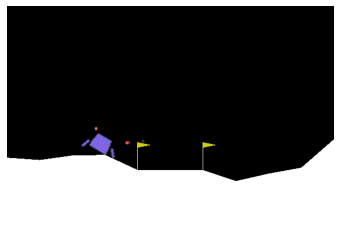

In [140]:
simulate(deep_q_agent, env)

### Training the `DeepQAgent`

Now I am finally ready to train the `deep_q_agent`. The target score for the `LunarLander-v2` environment is 200 points on average for at least 100 consecutive episodes. If the `deep_q_agent` is able to "solve" the environment, then training will terminate early.

In [59]:
scores = train(deep_q_agent, env, "checkpoint.pth", number_episodes=2000, target_score=200)

Episode 100	Average Score: -162.65
Episode 200	Average Score: -116.93
Episode 300	Average Score: -62.38
Episode 400	Average Score: -47.98
Episode 500	Average Score: 7.31
Episode 600	Average Score: 83.42
Episode 700	Average Score: 110.49
Episode 800	Average Score: 173.95
Episode 900	Average Score: 194.95

Environment solved in 909 episodes!	Average Score: 200.84


### Analyzing `DeepQAgent` performance

#### Simulating agent behavior

First step to analyzing agent performance is to re-run the simulation above with the trained agent to see the performance improvement on the task at hand. Assuming that the `deep_q_agent` was able to "solve" the task, running the simulation should show the lander gracefully landing in the designated landing area.

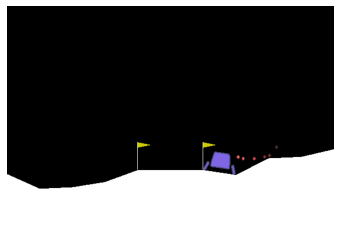

In [61]:
simulate(deep_q_agent, env)

#### Plotting the time series of scores

I can use [Pandas](https://pandas.pydata.org/) to quickly plot the time series of scores along with a 100 episode moving average. Note that training stops as soon as the rolling average crosses the target score.

In [62]:
scores = pd.Series(scores, name="scores")

In [63]:
scores.describe()

count    910.000000
mean      21.970552
std      178.287148
min     -540.156334
25%     -102.930508
50%       -2.251303
75%      208.804669
max      307.186852
Name: scores, dtype: float64

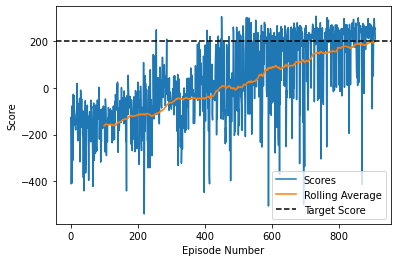

In [64]:
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="Scores")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.axhline(200, color='k', linestyle="dashed", label="Target Score")
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("Score")


#### Kernel density plot of the scores

Kernel density plot of scores is bimodal with one mode less than -100 and a second mode greater than 200. The negative mode corresponds to those training episodes where the agent crash landed and thus scored at most -100; the positive mode corresponds to those training episodes where the agent "solved" the task. The kernel density or scores typically exhibits negative skewness (i.e., a fat left tail): there are lots of ways in which landing the lander can go horribly wrong (resulting in the agent getting a very low score) and only relatively few paths to a gentle landing (and a high score).

Text(0.5, 0, 'Score')

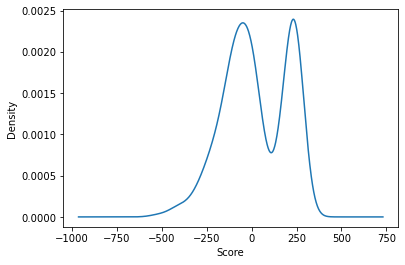

In [65]:
fig, ax = plt.subplots(1,1)
_ = scores.plot(kind="kde", ax=ax)
ax.set_xlabel("Score")

## Where to go from here?

I am a bit frustrated by lack of stability that I am seeing in my implmentation of the Deep Q algorithm: sometimes the algorithm converges and sometimes not. Perhaps more tuning of hyper-parameters or use of a different optimization algorithm would exhibit better convergence. I have already spent more time than I had allocated on playing around with this agorithm so I am not going to try and fine-tune the hyperparamters or explore alternative optimization algorithms for now.

Rather than spending time tuning hyperparameters, I think it would be better use of my time to explore algorithmic improvements. In future posts I plan to cover the following extensions of the DQN algorithm.

* [Double Q-Learning](https://arxiv.org/abs/1509.06461)
* [Prioritized Experience Replay](https://arxiv.org/abs/1509.06461)
* [Dueling Network Architectures](https://arxiv.org/abs/1511.06581)